In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [ ]:
from keras.models import load_model

pretrained_model = load_model("MobileNetV3Large.keras")

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

from tensorflow.keras.applications import MobileNetV3Large
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

from tensorflow.keras import Model


/Users/vpedos/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
TRAIN_DIR = 'plant_leave_disease_dataset/Cherry/train'
TEST_DIR = 'plant_leave_disease_dataset/Cherry/test'

train_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    validation_split = 0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=1,
    shuffle=False
)

In [7]:
# Resize Layer
resize_and_rescale = keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),                       
], name="data_augmentation")

In [8]:
print(len(train_images))
print(len(val_images))

153
38


In [9]:
# Load the pretained model
pretrained_model.trainable = False

In [21]:
from tensorflow.keras import Sequential

model_ = Sequential()

model_.add(Conv2D(32,kernel_size = (3,3), activation = 'relu', input_shape=(224,224,3)))
model_.add(BatchNormalization(axis=3))
model_.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model_.add(BatchNormalization(axis=3))
model_.add(AveragePooling2D(pool_size=(2,2)))

model_.add(Conv2D(64,kernel_size = (3,3), activation = 'relu'))
model_.add(BatchNormalization(axis=3))
model_.add(AveragePooling2D(pool_size=(2,2)))
model_.add(Dropout(0.3))

model_.add(Conv2D(128,kernel_size = (3,3), activation = 'relu'))
model_.add(BatchNormalization(axis=3))
model_.add(AveragePooling2D(pool_size=(2,2)))

model_.add(Conv2D(512,kernel_size = (3,3), activation = 'relu'))
model_.add(BatchNormalization(axis=3))
model_.add(GlobalAveragePooling2D())
model_.add(Dropout(0.3))

model_.add(Flatten())
model_.add(Dense(128, activation='relu'))
model_.add(Dropout(0.3))
model_.add(Dense(64, activation='relu'))
model_.add(Dropout(0.3))
model_.add(Dense(1, activation='sigmoid'))

model_.compile(
    loss = keras.losses.binary_crossentropy,
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [22]:
model_.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 220, 220, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 110, 110, 64)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 54, 54, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 26, 26, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 797,697 (3.04 MB)

 Trainable params: 796,097 (3.04 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [23]:
# Create checkpoint callback
checkpoint_path = "./Cherry CNN-Model/Checkpoint/model_cherry_scratch.keras"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=False,
                                      monitor="val_accuracy",
                                      save_best_only=True)


In [24]:
# Train the model
history_scratch = model_.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        EarlyStopping(patience = 5),
        checkpoint_callback,
    ]
)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.8877 - loss: 0.2404 - val_accuracy: 0.5461 - val_loss: 2.5910
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9701 - loss: 0.0818 - val_accuracy: 0.4507 - val_loss: 19.2443
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9597 - loss: 0.1063 - val_accuracy: 0.5329 - val_loss: 1.6506
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9788 - loss: 0.0597 - val_accuracy: 0.4474 - val_loss: 11.7070
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9677 - loss: 0.1021 - val_accuracy: 0.7697 - val_loss: 1.3337
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9666 - loss: 0.0936 - val_accuracy: 0.9572 - val_loss: 0.0934
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9755 - loss: 0.0602 - val_accuracy: 0.9770 - val_loss: 0.2580
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9798 - loss: 0.0828 

In [25]:
# Show metrics
train_acc, train_loss = model_.evaluate(train_images, verbose=0)
val_acc, val_loss = model_.evaluate(val_images, verbose=0)
test_acc, test_loss = model_.evaluate(test_images, verbose=0)
print("    Train Loss: {:.5f}".format(train_acc))
print("Train Accuracy: {:.2f}%".format(train_loss * 100))
print("    Valid Loss: {:.5f}".format(val_acc))
print("Valid Accuracy: {:.2f}%".format(val_loss * 100))
print("    Test Loss: {:.5f}".format(test_acc))
print("Test Accuracy: {:.2f}%".format(test_loss * 100))

    Train Loss: 0.86794
Train Accuracy: 83.11%
    Valid Loss: 0.85726
Valid Accuracy: 79.93%
    Test Loss: 0.93328
Test Accuracy: 81.94%


In [ ]:
from keras.models import load_model

model_.save('./Cherry CNN-Model/cherry_model_8_mobilenet_v3.keras')  

### Examples of cherry disease classification.

Created a dictionary for predicting test images with cherry disease labels. As a result of classification, the most probable cherry disease are identified and presented along with corresponding confidence values in percentage format.

In [26]:
# Create labels for model
output_labels = [name for name in list(train_images.class_indices)] 
n_classes = len(output_labels)

In [27]:
train_images.class_indices

{'Healthy': 0, 'Powdery mildew': 1}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
100.00% 	 Healthy


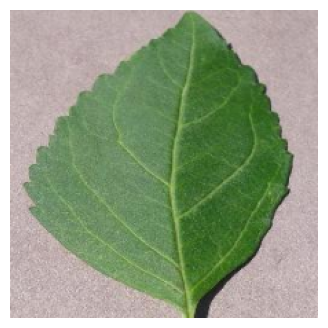

In [91]:
img = cv2.imread('plant_leave_disease_dataset/Cherry/test/Healthy/image (115).JPG')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rgb = cv2.resize(img_rgb, (224,224), interpolation = cv2.INTER_LINEAR)
plt.figure(figsize=(4, 4))
plt.imshow(img_rgb)
plt.axis('off')
test_img = preprocess_input(img_rgb)
probs = model_.predict(np.expand_dims(test_img, axis=0))
res = np.where(probs >0.5, 1,0)
print("{:.2f}%".format(100), "\t", labels[res[0][0]])
# for idx in res[0]:
#     print("{:.2f}%".format(res[0][0]*100), "\t", labels[idx])
# print(res)
# for idx in probs.argsort()[0][:1]:
#     print("{:.2f}%".format(probs[0][idx]*100), "\t", labels[idx])

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Confusion Matrix
Normalized confusion matrix
Classification Report
                precision    recall  f1-score   support

       Healthy       0.72      0.98      0.83       171
Powdery mildew       0.97      0.69      0.81       211

      accuracy                           0.82       382
     macro avg       0.85      0.83      0.82       382
  weighted avg       0.86      0.82      0.82       382



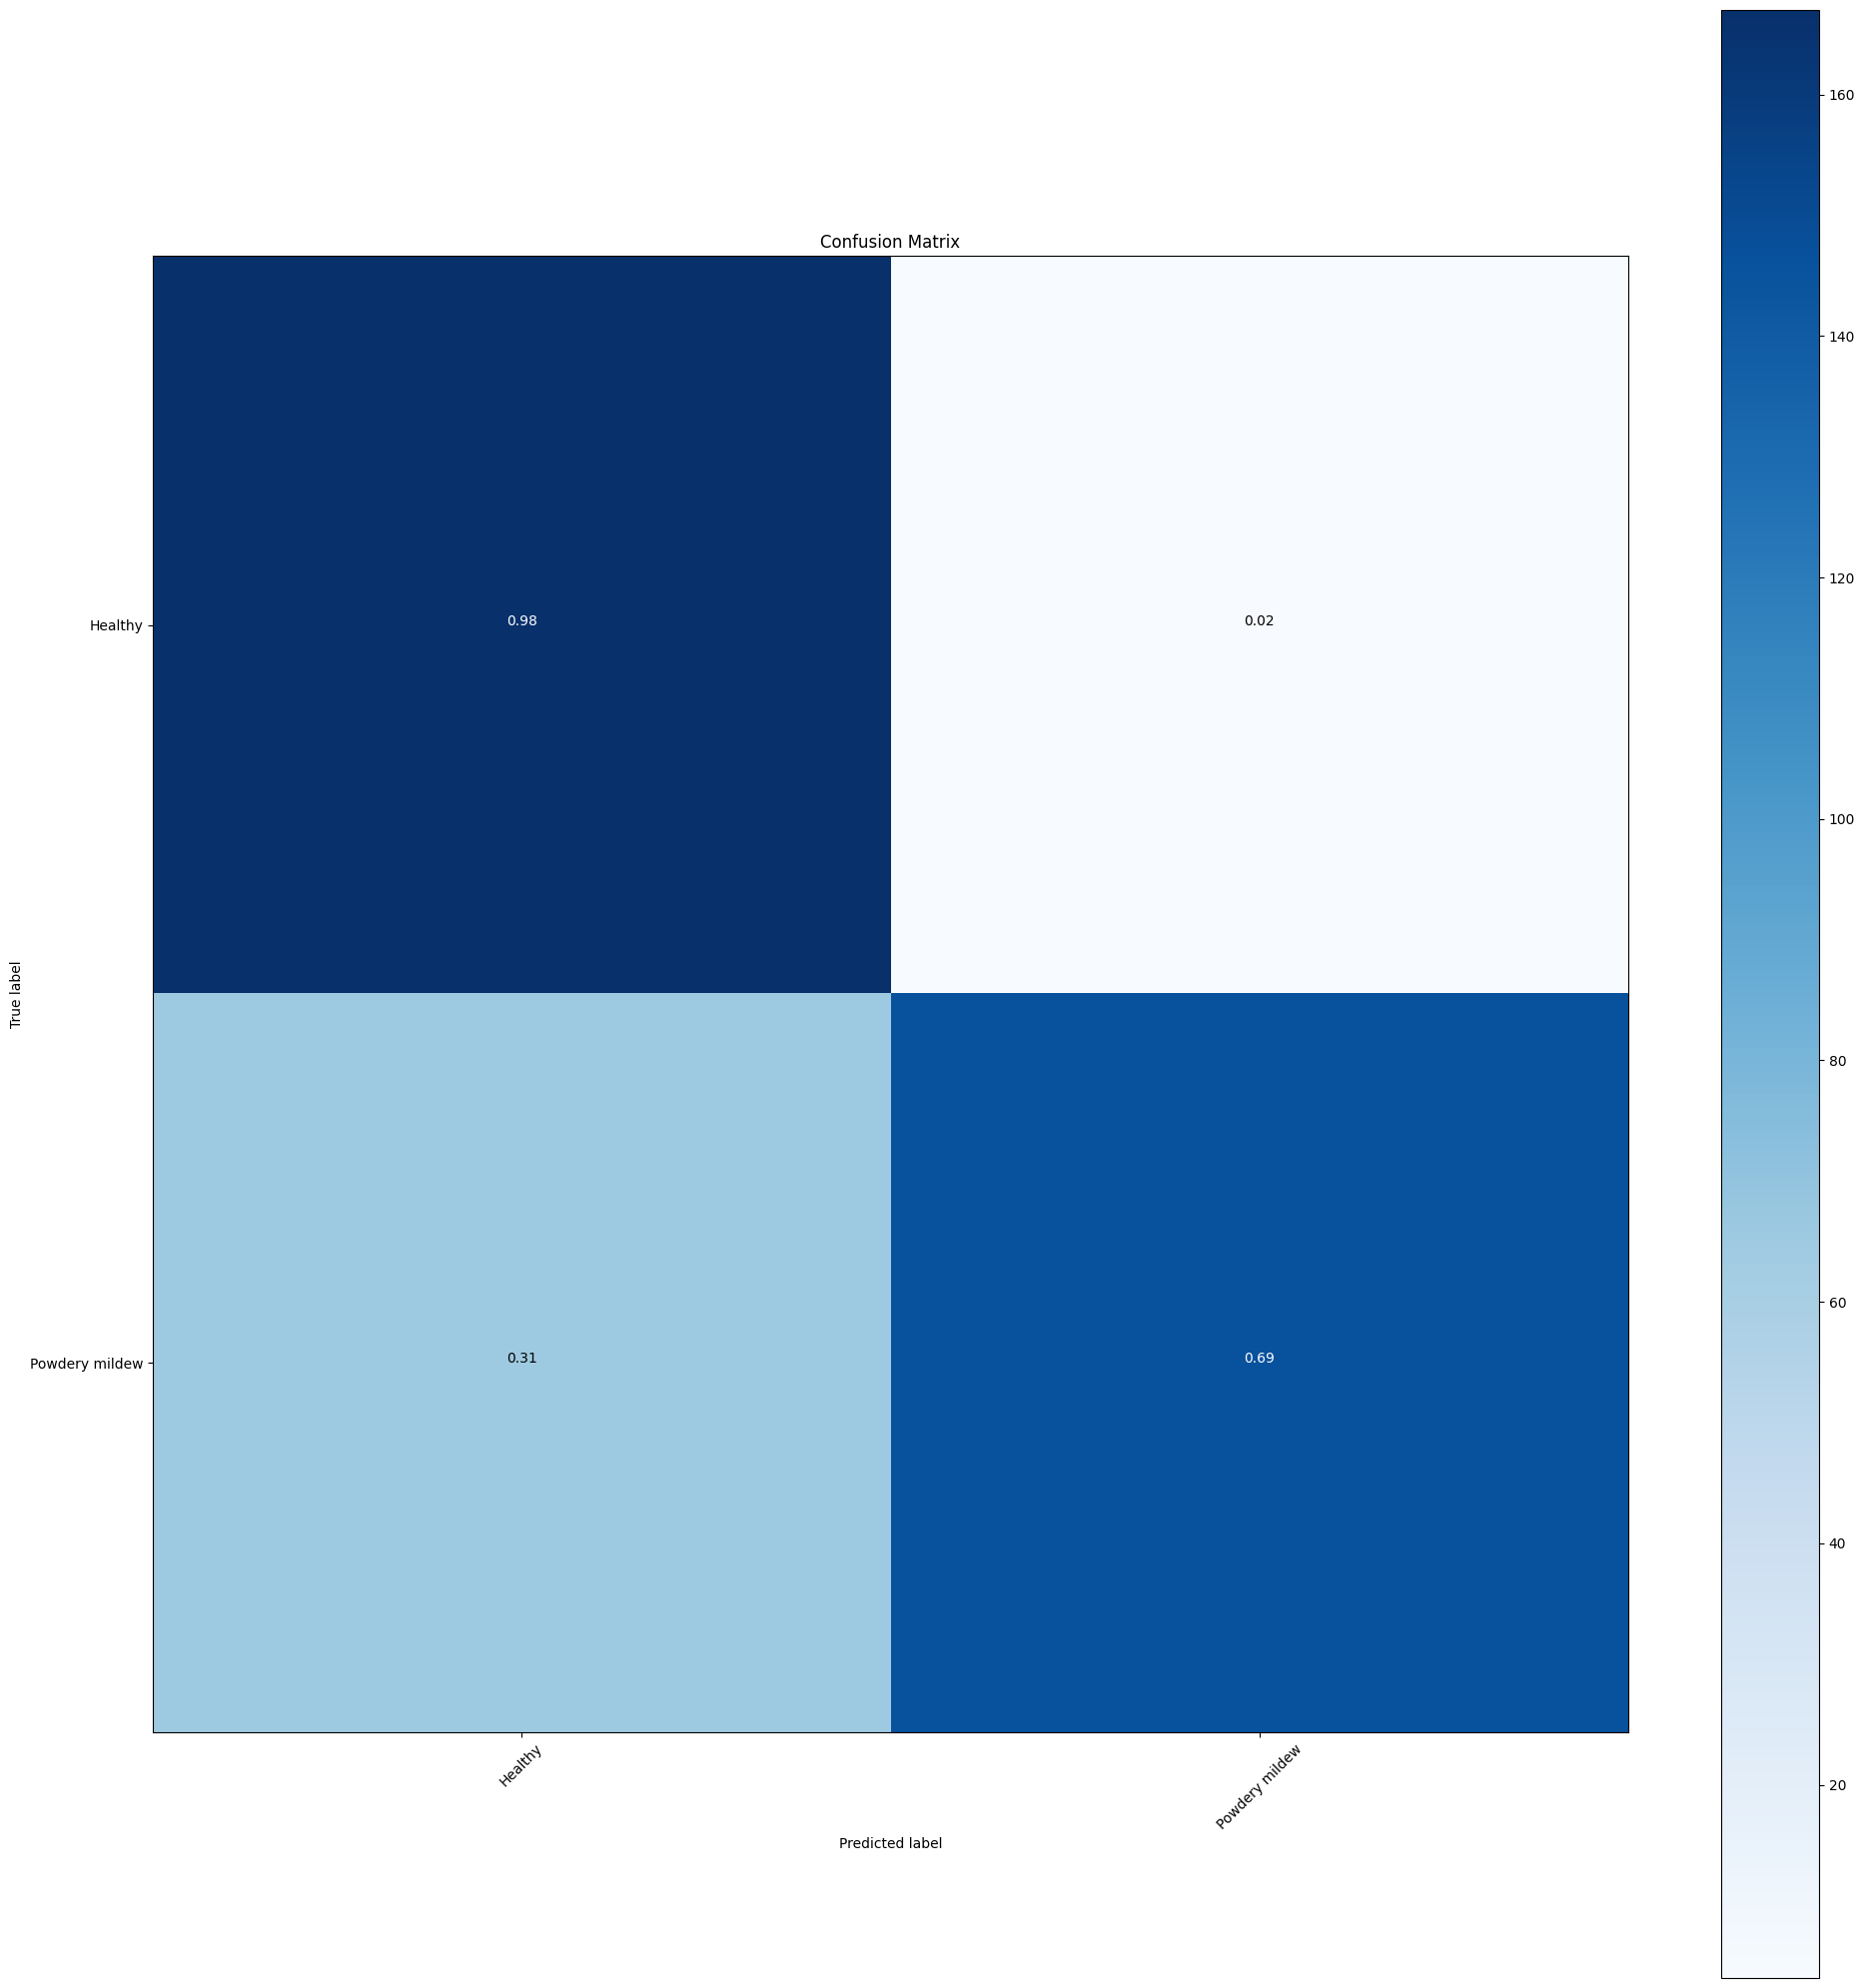

In [105]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_images.class_indices:
    target_names.append(key)

# print(target_names)
#Confution Matrix
Y_pred = model_.predict(test_images)
y_pred = (Y_pred>0.5).astype(int)
# y_pred = np.where(Y_pred >0.5, 1,0)
# y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_images.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_images.classes, y_pred, target_names=target_names))